In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.callbacks import  ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tqdm.auto import tqdm
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
df=pd.read_csv('dialect_with_sentences_pre_processed.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458023 entries, 0 to 458022
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        458023 non-null  int64 
 1   dialect   458023 non-null  object
 2   sentence  458023 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


## ML algorithm

In [ ]:
X_scv=df.sentence
y_scv=df.dialect

In [ ]:
X_train_scv, X_test_scv,y_train_scv,  y_test_scv = train_test_split(X_scv,y_scv, test_size=0.1, random_state=42)

X_train_scv_sample,__,y_train_scv_sample, _ = train_test_split(X_train_scv,y_train_scv, test_size=0.85, random_state=42)


In [ ]:
vec = TfidfVectorizer()
clf = SVC(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train_scv_sample,y_train_scv_sample)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(random_state=42))])

In [ ]:
pipe.score( X_test_scv,y_test_scv)

0.4209549592821431

### Saving the model

In [ ]:
filename = 'SVC_model.sav'
pickle.dump(pipe, open(filename, 'wb'))

## DL Algorithm

In [ ]:
X=df.sentence
y=df.dialect

In [ ]:
y.value_counts()

EG    57621
PL    43731
KW    42104
LY    36476
QA    31064
JO    27900
LB    27615
SA    26831
AE    26293
BH    26287
OM    19111
SY    16234
DZ    16179
IQ    15491
SD    14389
MA    11538
YE     9915
TN     9244
Name: dialect, dtype: int64

### Get how many is the vocab size

In [ ]:
l=[]
for x in X.str.split():
    l.extend(x)
result=list(set(l))
vocab_size=len(result)
vocab_size

464805

### Get the distribution of sentences length to decide the maximum length of the sentence

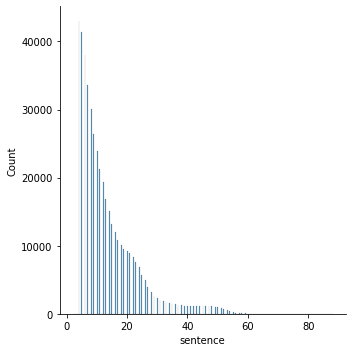

In [ ]:
sns.displot(X.str.split().apply(len))

In [ ]:
max_sequence_len=60

### Encode the vocab, every word has its own id 

In [ ]:
encoded_x = [one_hot(d, vocab_size) for d in X]

In [ ]:
encoded_x[:3]

[[12296, 237536, 137366, 156900],
 [443921,
  23178,
  269530,
  11990,
  6499,
  49122,
  100736,
  29662,
  103121,
  97590,
  247637,
  162947,
  452562,
  296619,
  283545],
 [66435, 103121, 211919, 65347]]

In [ ]:
one_hot('لكن',vocab_size,)

[12296]

### Saving a dataset of word and their corresponding ids to be used later in deployment.

In [ ]:
ids= [i for d in result for i in one_hot(d, len(result))]
idToWord=pd.DataFrame({'id':ids,"word":result})
idToWord.to_csv('idToWord.csv',index=False)

### Padding all the sentences whose length are less than the maximum sequence length

In [ ]:
X_padded = np.zeros((X.shape[0], max_sequence_len))
for i, sent in enumerate(encoded_x):
    X_padded[i, :len(sent)] = sent[:max_sequence_len]

In [ ]:
X_padded[:3]

array([[ 12296., 237536., 137366., 156900.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.],
       [443921.,  23178., 269530.,  11990.,   6499.,  49122., 100736.,
         29662., 103121.,  97590., 247637., 162947., 452562., 296619.,
        283545.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0

### One hot encoding the target

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

In [ ]:
pd.Series(encoded_y).value_counts()

3     57621
11    43731
6     42104
8     36476
12    31064
5     27900
7     27615
13    26831
0     26293
1     26287
10    19111
15    16234
2     16179
4     15491
14    14389
9     11538
17     9915
16     9244
dtype: int64

### Defining the architecture of the DL and adding an Embedding layer to customize an embedding for this use case.

In [ ]:
model_bi = tf.keras.models.Sequential([    
    tf.keras.layers.Embedding(vocab_size,64,input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

In [ ]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [ chkpt, early_stopping]

In [ ]:
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation")])

In [ ]:
X_train, X_test,y_train,  y_test = train_test_split(X_padded, dummy_y, test_size=0.1, random_state=42)


In [ ]:
X_train.shape

(412220, 60)

In [ ]:
y_train.shape

(412220, 18)

In [ ]:
model_bi.fit(X_train, y_train, epochs=3, batch_size=128,validation_split=0.2,callbacks=callbacks)


Epoch 1/3
2577/2577 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.3702 - auc: 0.8590
Epoch 1: val_loss improved from inf to 1.67260, saving model to model_weights.h5
2577/2577 [==============================] - 218s 80ms/step - loss: 1.9702 - accuracy: 0.3702 - auc: 0.8590 - val_loss: 1.6726 - val_accuracy: 0.4706 - val_auc: 0.9021
Epoch 2/3
2577/2577 [==============================] - ETA: 0s - loss: 1.3023 - accuracy: 0.5896 - auc: 0.9415
Epoch 2: val_loss improved from 1.67260 to 1.60127, saving model to model_weights.h5
2577/2577 [==============================] - 202s 79ms/step - loss: 1.3023 - accuracy: 0.5896 - auc: 0.9415 - val_loss: 1.6013 - val_accuracy: 0.5037 - val_auc: 0.9098
Epoch 3/3
2577/2577 [==============================] - ETA: 0s - loss: 0.8587 - accuracy: 0.7360 - auc: 0.9727
Epoch 3: val_loss did not improve from 1.60127
2577/2577 [==============================] - 202s 78ms/step - loss: 0.8587 - accuracy: 0.7360 - auc: 0.9727 - val_loss

In [ ]:
model_json = model_bi.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation")])
loaded_model.evaluate(X_test, y_test)

1432/1432 [==============================] - 42s 26ms/step - loss: 1.6004 - accuracy: 0.5045 - auc_1: 0.9098


[1.6004271507263184, 0.5045084357261658, 0.9098253846168518]